This IPython notebook contains supplementary materials for the column:

Marinka Zitnik <br />
**The Infinite Mixtures of Food Products** <br />
[ACM XRDS](http://xrds.acm.org), 23, 2016.

In [1]:
import math

import numpy as np
import pandas as pd
from numpy.linalg import cholesky, det, inv, slogdet
import scipy as sp
import seaborn as sns
from scipy import stats
from scipy.special import gammaln
from scipy.misc import logsumexp
from sklearn import datasets, preprocessing
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

sns.set_style('white')

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# A toy example of Gibbs sampling

Suppose we want to find out how many people liked a particular movie. We have a group of $n$ people and have sent them to a couple of theaters. 

We recorded two quantities:
* $x$ - how many people, among $n$ people, like the movie, and
* $y$ - what fraction of the theather was occupied.

We now define a joint distribution of variables, $x$ and $y$. Let us suppose that the joint distribution of $x$, $x = 0, 1, \dots, n,$ and $y$, $0 \le y \le 1,$ is given by:

$$
p(x, y) = \frac{n!}{(n-x)! x!}y^{x+\alpha-1} (1-y)^{n-x+\beta-1}.
$$

In this case, $x$ is discrete and $y$ is continuous. We see that:

$$ p(x|Y=y) = Binom(n, y),$$
$$ P(y|X=x) = Beta(x+\alpha, n-x+\beta).$$

To compute any feature of either marginal distribution we proceed as follows. We compute a sequence of values by sampling from a univariate binomial and beta distributions in an alternating fashion conditioning on the values that were sampled in the previous step. In order to start the computation for our theather example, the user has to define the initial value for $y$. However, the dependence on the initial value of $y$ decays as the sequence length increases. It is hence often desirable to start recording the sequence after a sufficient number of burn-in iterations have occurred to remove any effects of the starting conditions. The procedure outlined here is a popular Markov chain Monte Carlo (MCMC) approach, known as Gibbs sampling, which is the MCMC analog of coordinate descent algorithm. 

**Using Gibbs sampler to calculate features of interest**

We can use Gibbs sampler to calculate any feature of interest from the sequence we obtain. For example, we can calculate the expectation of a function $g$ of the random variable $X$ as $E[g(X)]_m = 1/m \sum_{i=1}^m g(x^{(i)})$, where $m$ is the number of sequences that were generated using the Gibbs sampler. This is the Monte-Carlo estimate of $g(x)$, so that $E[g(X)]_m \rightarrow E[g(X)]$ when $m \rightarrow \infty$. It is straightforward to generalize it to more than one random variable. 

Similarly, we can also obtain mean, variance and other features of interest.

**References**

[1] Murphy, K. P. (2012). *Machine learning: a probabilistic perspective.* MIT Press.

[2] Rasmussen, C. E. (1999). The infinite Gaussian mixture model. In *NIPS,* 554-560.

[3] Yerebakan, H. Z., Rajwa, B., & Dundar, M. (2014). The infinite mixture of infinite Gaussian mixtures. In *NIPS,* 28-36.

[4] Liu, C. L., Tsai, T. H., & Lee, C. H. (2014). Online Chinese restaurant process. In *ACM SIGKDD,* 591-600.

[5] Kyung, M., Gill, J., & Casella, G. (2011). New findings from terrorism data: Dirichlet process random-effects models for latent groups. *Journal of the Royal Statistical Society: Series C (Applied Statistics),* 60(5), 701-721.

In [2]:
def toy_gibbs(n_sample, n, alpha, beta):
    y = np.empty(n_sample)
    x = np.empty(n_sample)
    y[0] = 0.5
    x[0] = stats.binom.rvs(n, y[0])
    for i in range(1, n_sample):
        y[i] = stats.beta.rvs(x[i-1]+alpha, n-x[i-1]+beta)
        x[i] = stats.binom.rvs(n, y[i])
    return x, y

In [3]:
# Gelfand and Smith suggest generating m independent Gibbs sequences of length k and using the final value of X_k 
# from each sequence.
M = 5000
xs, ys = [], []
for _ in range(M):
    x, y = toy_gibbs(20, 10, 2, 4)
    xs.append(x)
    ys.append(y)

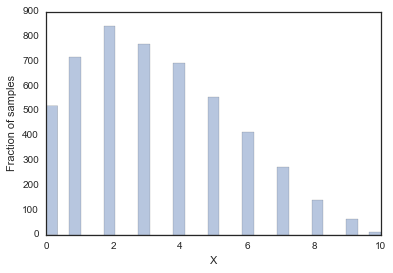

In [4]:
# the distribution of x generated from this code looks like
x_to_plot = np.array([x[-1] for x in xs])
sns.distplot(x_to_plot, kde=False)
plt.xlabel('X');
plt.ylabel('Fraction of samples');

# Infinite Gaussian mixture model with a collapsed Gibbs sampler

In [5]:
# ============================================================================================
# The code for infinite Bayesian Gausssian mixture model (IGMM) is adapted from Bayes GMM:
#
# http://github.com/kamperh/bayes_gmm (Herman Kamper)
# 
# Reference: 
# H. Kamper, A. Jansen, S. King, and S. Goldwater, "Unsupervised lexical clustering of speech 
# segments using fixed-dimensional acoustic embeddings", in Proceedings of the IEEE Spoken 
# Language Technology Workshop (SLT), 2014. 
# ============================================================================================

In [6]:
class GaussianComponentsDiag(object):
    """
    Components of a Bayesian Gaussian mixture model (GMM) with diagonal
    covariance matrices.

    This class is used to present the `K` components of a Bayesian GMM. All
    values necessary for computing likelihood terms are stored. For example,
    `m_N_numerators` is a KxD matrix in which each D-dimensional row vector is
    the numerator for the m_N term (4.210) in Murphy, p. 134 for each of the
    `K` components. A NxD data matrix `X` and a Nx1 assignment vector
    `assignments` are also attributes of this class. In the member functions,
    `i` generally refers to the index of a data vector while `k` refers to the
    index of a mixture component. The full covariance version of this class is
    `gaussian_components.GaussianComponents`.

    Parameters
    ----------
    X : NxD matrix
        A matrix of N data vectors, each of dimension D.
    prior : `NIW`
        The normal-inverse-chi-squared prior. It has the same attributes as
        the `NIW` distribution, so the same class can be used. The S_0 member,
        however, should be a D-dimensional vector rather than a matrix.
    assignments : Nx1 vector of int
        The initial component assignments. Components should be labelled from 0.
    K_max : int
        The maximum number of components. If this value is None, then K_max is
        set to N, the number of data vectors.

    Global attributes
    -----------------
    N : int
        Number of data vectors.
    D : int 
        Dimensionality of data vectors.
    K : int
        Number of Gaussian components.

    Component attributes
    --------------------
    m_N_numerators : KxD matrix
        The numerator of (4.210) in Murphy, p. 134 for each component. This
        does not change for the diagonal covariance case.
    S_N_partials : KxD matrix
        The partial D-dimensional vector of the sum of squares S_0 + S +
        k_0*m_0.^2 (see (138) in the Murphy's bayesGauss notes) for each of the
        K components. The i'th element in one of these D-dimensional vectors is
        the partial sum of squares for the i'th univariate posterior
        distribution.
    log_prod_vars : Kx1 vector of float
        In the diagonal covariance matrix case, this is the log of the product
        of the D variances for each of the K components. This is used in
        calculating the product of the univariate Student's t distributions.
    inv_vars : KxD matrix
        Each D-dimensional row vector is the inverse of the variances on the
        diagonal of the covariance matrix.
    counts : Kx1 vector of int
        Counts for each of the K components.
    """

    def __init__(self, X, prior, assignments, K_max=None):
        # Attributes from parameters
        self.X = X
        self.prior = prior
        self.N, self.D = X.shape
        if K_max is None:
            K_max = self.N
        self.K_max = K_max

        # Check shape of S_0 in prior
        assert len(prior.S_0.shape) == 1, "For diagonal covariance, S_0 needs to be vector."

        # Initialize attributes
        self.m_N_numerators = np.zeros((self.K_max, self.D), np.float)
        self.S_N_partials = np.zeros((self.K_max, self.D), np.float)
        self.log_prod_vars = np.zeros(self.K_max, np.float)
        self.inv_vars = np.zeros((self.K_max, self.D), np.float)
        self.counts = np.zeros(self.K_max, np.int)

        # Perform caching
        self._cache()

        # Initialize components based on `assignments`
        self.K = 0

        # Check that assignments are valid
        assignments = np.asarray(assignments, np.int)
        assert (self.N, ) == assignments.shape
        # Apart from unassigned (-1), components should be labelled from 0
        assert set(assignments).difference([-1]) == set(range(assignments.max() + 1))
        self.assignments = assignments

        # Add the data items
        for k in range(self.assignments.max() + 1):
            for i in np.where(self.assignments == k)[0]:
                self.add_item(i, k)

    def _cache(self):
        self._cached_prior_square_m_0 = np.square(self.prior.m_0)

        self._cached_square = np.zeros((self.N, self.D), np.float)
        self._cached_square = np.square(self.X)

        n = np.concatenate([[1], np.arange(1, self.prior.v_0 + self.N + 2)])  # first element dud for indexing
        self._cached_log_v = np.log(n)
        self._cached_gammaln_by_2 = gammaln(n/2.)
        self._cached_log_pi = math.log(np.pi)

        self.cached_log_prior = np.zeros(self.N, np.float)
        for i in xrange(self.N):
            self.cached_log_prior[i] = self.log_prior(i)

    def cache_component_stats(self, k):
        """
        Return the statistics for component `k` in a tuple.

        In this way the statistics for a component can be cached and can then
        be restored later using `restore_component_from_stats`.
        """
        return (
            self.m_N_numerators[k].copy(),
            self.S_N_partials[k].copy(),
            self.log_prod_vars[k],
            self.inv_vars[k].copy(),
            self.counts[k]
            )

    def restore_component_from_stats(
            self, k, m_N_numerator, S_N_partial, log_prod_var, inv_var, count
            ):
        """Restore component `k` using the provided statistics."""
        self.m_N_numerators[k, :] = m_N_numerator
        self.S_N_partials[k, :] = S_N_partial
        self.log_prod_vars[k] = log_prod_var
        self.inv_vars[k, :] = inv_var
        self.counts[k] = count

    def add_item(self, i, k):
        """
        Add data vector `X[i]` to component `k`.

        If `k` is `K`, then a new component is added. No checks are performed
        to make sure that `X[i]` is not already assigned to another component.
        """
        if k == self.K:
            self.K += 1
            self.m_N_numerators[k, :] = self.prior.k_0*self.prior.m_0
            self.S_N_partials[k, :] = self.prior.S_0 + self.prior.k_0*self._cached_prior_square_m_0
        self.m_N_numerators[k, :] += self.X[i]
        self.S_N_partials[k, :] += self._cached_square[i]
        self.counts[k] += 1
        self._update_log_prod_vars_and_inv_vars(k)
        self.assignments[i] = k

    def del_item(self, i):
        """Remove data vector `X[i]` from its component."""
        k = self.assignments[i]

        # Only do something if the data vector has been assigned
        if k != -1:
            self.counts[k] -= 1
            self.assignments[i] = -1
            if self.counts[k] == 0:
                # Can just delete the component, don't have to update anything
                self.del_component(k)
            else:
                # Update the component
                self.m_N_numerators[k, :] -= self.X[i]
                self.S_N_partials[k, :] -= self._cached_square[i]
                self._update_log_prod_vars_and_inv_vars(k)

    def del_component(self, k):
        """Remove the component `k`."""
        self.K -= 1
        if k != self.K:
            # Put stats from last component into place of the one being removed
            self.m_N_numerators[k] = self.m_N_numerators[self.K]
            self.S_N_partials[k, :] = self.S_N_partials[self.K, :]
            self.log_prod_vars[k] = self.log_prod_vars[self.K]
            self.inv_vars[k, :] = self.inv_vars[self.K, :]
            self.counts[k] = self.counts[self.K]
            self.assignments[np.where(self.assignments == self.K)] = k
        # Empty out stats for last component
        self.m_N_numerators[self.K].fill(0.)
        self.S_N_partials[self.K, :].fill(0.)
        self.log_prod_vars[self.K] = 0.
        self.inv_vars[self.K, :].fill(0.)
        self.counts[self.K] = 0

    def log_prior(self, i):
        """Return the probability of `X[i]` under the prior alone."""
        mu = self.prior.m_0
        var = (self.prior.k_0 + 1.) / (self.prior.k_0*self.prior.v_0) * self.prior.S_0
        log_prod_var = np.log(var).sum()
        inv_var = 1./var
        v = self.prior.v_0
        return self._log_prod_students_t(i, mu, log_prod_var, inv_var, v)

    def log_post_pred_k(self, i, k):
        """
        Return the log posterior predictive probability of `X[i]` under
        component `k`.
        """
        k_N = self.prior.k_0 + self.counts[k]
        v_N = self.prior.v_0 + self.counts[k]
        m_N = self.m_N_numerators[k]/k_N
        mu = m_N
        v = v_N
        return self._log_prod_students_t(i, mu, self.log_prod_vars[k], self.inv_vars[k], v)

    def log_post_pred(self, i):
        """
        Return a `K`-dimensional vector of the posterior predictive of `X[i]`
        under all components.
        """
        k_Ns = self.prior.k_0 + self.counts[:self.K]
        v_Ns = self.prior.v_0 + self.counts[:self.K]
        m_Ns = self.m_N_numerators[:self.K]/k_Ns[:, np.newaxis]

        studentt_gammas = self._cached_gammaln_by_2[v_Ns  + 1] - self._cached_gammaln_by_2[v_Ns]

        deltas = m_Ns - self.X[i]

        return (
            self.D * (
                studentt_gammas
                - 0.5*self._cached_log_v[v_Ns] - 0.5*self._cached_log_pi
                )
            - 0.5*self.log_prod_vars[:self.K]
            - (v_Ns + 1)/2. * sum_axis1(np.log(
                1 + np.square(deltas)*self.inv_vars[:self.K]*(1./v_Ns[:, np.newaxis])
                ))
            )

    def log_marg_k(self, k):
        """
        Return the log marginal probability of the data vectors assigned to
        component `k`.

        The log marginal probability p(X) = p(x_1, x_2, ..., x_N) is returned
        for the data vectors assigned to component `k`. See (171) in Murphy's
        bayesGauss notes, p. 15.
        """
        k_N = self.prior.k_0 + self.counts[k]
        v_N = self.prior.v_0 + self.counts[k]
        m_N = self.m_N_numerators[k]/k_N
        S_N = self.S_N_partials[k] - k_N*np.square(m_N)
        return (
            - self.counts[k]*self.D/2.*self._cached_log_pi
            + self.D/2.*math.log(self.prior.k_0) - self.D/2.*math.log(k_N)
            + self.prior.v_0/2.*np.log(self.prior.S_0).sum()
            - v_N/2.*np.log(S_N).sum()
            + self.D*(self._cached_gammaln_by_2[v_N] - self._cached_gammaln_by_2[self.prior.v_0])
            )

    def log_marg(self):
        """
        Return the log marginal probability of all the data vectors given the
        component `assignments`.

        The log marginal probability of
        p(X|z) = p(x_1, x_2, ... x_N | z_1, z_2, ..., z_N) is returned.
        """
        log_prob_X_given_z = 0.
        for k in xrange(self.K):
            log_prob_X_given_z += self.log_marg_k(k)
        return log_prob_X_given_z

    def rand_k(self, k):
        """
        Return a random mean and variance vector from the posterior product of
        normal-inverse-chi-squared distributions for component `k`.
        """

        k_N = self.prior.k_0 + self.counts[k]
        v_N = self.prior.v_0 + self.counts[k]
        m_N = self.m_N_numerators[k]/k_N
        S_N = self.S_N_partials[k] - k_N*np.square(m_N)

        mean = np.zeros(self.D)
        var = np.zeros(self.D)

        for i in range(self.D):
            var[i] = invchisquared_sample(v_N, S_N[i]/v_N, 1)[0]
            mean[i] = np.random.normal(m_N[i], np.sqrt(var[i]/k_N))

        return mean, var

    def _update_log_prod_vars_and_inv_vars(self, k):
        """
        Update the variance terms for the posterior predictive distribution of
        component `k`.

        Based on the `m_N_numerators` and `S_N_partials` terms for the `k`th
        component, the `log_prod_vars` and `inv_vars` terms are updated.
        """
        k_N = self.prior.k_0 + self.counts[k]
        v_N = self.prior.v_0 + self.counts[k]
        m_N = self.m_N_numerators[k]/k_N
        var = (k_N + 1.)/(k_N*v_N) * (self.S_N_partials[k] - k_N*np.square(m_N))
        self.log_prod_vars[k] = np.log(var).sum()
        self.inv_vars[k, :] = 1./var

    def _log_prod_students_t(self, i, mu, log_prod_var, inv_var, v):
        """
        Return the value of the log of the product of the univariate Student's
        t PDFs at `X[i]`.
        """
        delta = self.X[i, :] - mu
        return (
            self.D * (
                self._cached_gammaln_by_2[v + 1] - self._cached_gammaln_by_2[v]
                - 0.5*self._cached_log_v[v] - 0.5*self._cached_log_pi
                )
            - 0.5*log_prod_var
            - (v + 1.)/2. * (np.log(1. + 1./v * np.square(delta) * inv_var)).sum()
            )
    

sum_axis1 = lambda A: np.einsum("ij->i", A)


def students_t(x, mu, var, v):
    """
    Return the value of the log Student's t PDF at `x`.
    See Murphy's bayesGauss notes, p. 26. This function is mainly used for
    testing purposes, specifically for comparison with
    `GaussianComponentsDiag._log_prod_students_t`.
    """
    c = gammaln((v + 1)/2.) - gammaln(v/2.) - 0.5*(math.log(v) + math.log(np.pi) + math.log(var))
    return c - (v + 1)/2. * math.log(1 + 1./v*(x - mu)**2/var)


def log_post_pred_unvectorized(gmm, i):
    """
    Return the same value as `GaussianComponentsDiag.log_post_pred` but using
    an unvectorized procedure, for testing purposes.
    """
    post_pred = np.zeros(gmm.K, np.float)
    for k in range(gmm.K):
        post_pred[k] = gmm.log_post_pred_k(i, k)
    return post_pred


def invchisquared_sample(df, scale, size):
    """Return `size` samples from the inverse-chi-squared distribution."""

    # Parametrize inverse-gamma
    alpha = df/2  
    beta = df*scale/2.

    # Parametrize gamma
    k = alpha
    theta = 1./beta

    gamma_samples = np.random.gamma(k, theta, size)
    return 1./gamma_samples

In [7]:
class IGMM(object):
    """
    An infinite Gaussian mixture model (IGMM).

    Parameters
    ----------
    alpha : float
        Concentration parameter for the Dirichlet process.
    K : int
        The initial number of mixture components
    """

    def __init__(self, X, prior, alpha, K=1, K_max=None):

        self.alpha = alpha
        N, D = X.shape

        # Initial component assignments
        assignments = np.random.randint(0, K, N)

        # Make sure we have consequetive values
        for k in xrange(assignments.max()):
            while len(np.nonzero(assignments == k)[0]) == 0:
                assignments[np.where(assignments > k)] -= 1
            if assignments.max() == k:
                break

        self.components = GaussianComponentsDiag(X, prior, assignments, K_max)

    def log_marg(self):
        """Return log marginal of data and component assignments: p(X, z)"""

        # Log probability of component assignment P(z|alpha)
        # Equation (10) in Wood and Black, 2008
        # Use \Gamma(n) = (n - 1)!
        facts_ = gammaln(self.components.counts[:self.components.K])
        facts_[self.components.counts[:self.components.K] == 0] = 0  # definition of log(0!)
        log_prob_z = (
            (self.components.K - 1)*math.log(self.alpha) + gammaln(self.alpha)
            - gammaln(np.sum(self.components.counts[:self.components.K])
            + self.alpha) + np.sum(facts_)
            )

        log_prob_X_given_z = self.components.log_marg()

        return log_prob_z + log_prob_X_given_z


    def gibbs_sample(self, n_iter):
        """Perform `n_iter` iterations Gibbs sampling on the IGMM."""
        # Loop over iterations
        for i_iter in range(n_iter):

            # Loop over data items
            for i in xrange(self.components.N):

                # Cache some old values for possible future use
                k_old = self.components.assignments[i]
                K_old = self.components.K
                stats_old = self.components.cache_component_stats(k_old)

                # Remove data vector `X[i]` from its current component
                self.components.del_item(i)

                # Compute log probability of `X[i]` belonging to each component
                log_prob_z = np.zeros(self.components.K + 1, np.float)
                # (25.35) in Murphy, p. 886
                log_prob_z[:self.components.K] = np.log(self.components.counts[:self.components.K])
                # (25.33) in Murphy, p. 886
                log_prob_z[:self.components.K] += self.components.log_post_pred(i)
                # Add one component to which nothing has been assigned
                log_prob_z[-1] = math.log(self.alpha) + self.components.cached_log_prior[i]
                prob_z = np.exp(log_prob_z - logsumexp(log_prob_z))

                # Sample the new component assignment for `X[i]`
                k = np.random.choice(len(prob_z), p=prob_z)

                # Add data item X[i] into its component `k`
                if k == k_old and self.components.K == K_old:
                    # Assignment same and no components have been removed
                    self.components.restore_component_from_stats(k_old, *stats_old)
                    self.components.assignments[i] = k_old
                else:
                    # Add data item X[i] into its new component `k`
                    self.components.add_item(i, k)

# A demo application of the infinite Gaussian mixture model

In [8]:
colors = np.array([x for x in "bgrcmykbgrcmykbgrcmykbgrcmyk"])
colors = np.hstack([colors] * 20)

def plot_ellipse(ax, mu, sigma, color="b"):
    """
    Based on
    http://stackoverflow.com/questions/17952171/not-sure-how-to-fit-data-with-a-gaussian-python.
    """

    # Compute eigenvalues and associated eigenvectors
    vals, vecs = np.linalg.eigh(sigma)

    # Compute "tilt" of ellipse using first eigenvector
    x, y = vecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))

    # Eigenvalues give length of ellipse along each eigenvector
    w, h = 2 * np.sqrt(vals)
    ellipse = Ellipse(mu, w, h, theta, color=color)  # color="k")
    ellipse.set_clip_box(ax.bbox)
    ellipse.set_alpha(0.2)
    ax.add_artist(ellipse)


def plot_mixture_model(ax, model):
    X = np.array(model.components.X)
    ax.scatter(X[:, 0], X[:, 1], color=colors[model.components.assignments].tolist(), s=10)

In [9]:
class NIW(object):
    """A normal-inverse-Wishart distribution."""
    def __init__(self, m_0, k_0, v_0, S_0):
        self.m_0 = m_0
        self.k_0 = k_0
        D = len(m_0)
        assert v_0 >= D, "v_0 must be larger or equal to dimension of data"
        self.v_0 = v_0
        self.S_0 = S_0

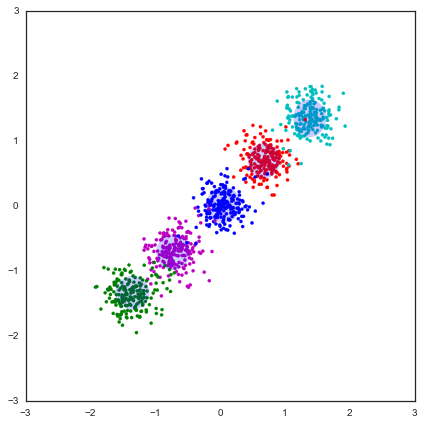

In [10]:
np.random.seed(0)

# Model parameters
alpha = 1.
# initial number of components
K = 10
n_iter = 20

# Generate data
n_feat = 2
n_cluster = 5
centers = np.array([[i]*2 for i in range(n_cluster)])

X, y = datasets.make_blobs(n_samples=1000, centers=centers, cluster_std=0.3, 
                           n_features=n_feat, random_state=0)
X = preprocessing.StandardScaler().fit_transform(X)

# Intialize prior|
m_0 = np.zeros(n_feat)
k_0 = 0.01 
v_0 = n_feat + 3
S_0 = 1.**2*v_0*np.ones(n_feat)
prior = NIW(m_0, k_0, v_0, S_0)

# Setup IGMM
igmm = IGMM(X, prior, alpha, K=K)

# Perform Gibbs sampling
record = igmm.gibbs_sample(n_iter)

# Plot results
f, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_mixture_model(ax, igmm)

for k in xrange(igmm.components.K):
    mu, sigma = igmm.components.rand_k(k)
    plot_ellipse(ax, mu, np.diag(sigma))

plt.tight_layout()

# Clustering the food product facts

The Open Food Facts (http://world.openfoodfacts.org) is a collaborative, free and open database of food products from around the world. For the purpose of this column we retrieved data for 2,776 food products sold in the United States (accessed on June 30, 2016). Examples of the products include various brands of crunchy peanut butter, chocolate, bread, meat and foods from other categories. For each product, we retrieved a list of ingredients together with the associated quantities, nutrition facts, and characteristics of the product.

We represent each product with a vector of real values, such that categorical items are encoded with binary variables and numerical items are normalized to report values for equal item size (i.e., 100 grams or 100 milliliters). Additionally, we remove features with low variance and food products with empty data profiles.

## Load the food product data and initialize the prior

In [11]:
# Load the data
data = np.loadtxt('food_products.tsv', delimiter='\t', dtype=object)
X = data[1:, 7:].astype('float')

# Model parameters
alpha = 10
# Initial number of components
K = 100
n_iter = 50

# Intialize prior
X  = preprocessing.StandardScaler().fit_transform(X)
n_sample, n_feat = X.shape
m_0 = np.zeros(n_feat)
k_0 = 1.
v_0 = n_feat + 3
S_0 = 1.**2*v_0*np.ones(n_feat)
prior = NIW(m_0, k_0, v_0, S_0)

In [12]:
def run_igmm(X, prior, alpha, K, n_iter, n_run=10):
    igmms = []
    for i in xrange(n_run):
        igmm = IGMM(X, prior, alpha, K=K)
        igmm.gibbs_sample(n_iter)
        igmms.append(igmm)
    return igmms

##  Food clusters

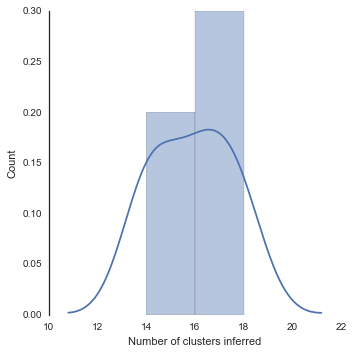

In [13]:
np.random.seed(0)

# We run the Gibbs sampler 10 times
igmms = run_igmm(X, prior, alpha, K, n_iter, n_run=10)
# We see that the number of discovered clusters tend to be a number around 16
cluster_number = np.array([igmm.components.K for igmm in igmms])

f, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.distplot(cluster_number);

sns.despine(bottom=True)
plt.xlabel('Number of clusters inferred')
plt.ylabel('Count')
plt.tight_layout()

## Evaluating food clusters based on their nutritional profiles

In [14]:
np.random.seed(0)

igmm = IGMM(X, prior, alpha, K=K)
igmm.gibbs_sample(n_iter)

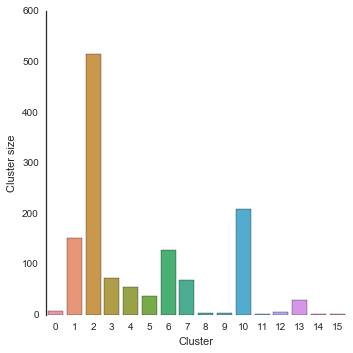

In [15]:
# We plot cluster size distribution
f, ax = plt.subplots(1, 1, figsize=(5, 5))

to_plot = [[np.sum(igmm.components.assignments == i)] for i in range(igmm.components.K)]
sns.barplot(data=to_plot);

sns.despine(bottom=True)
plt.xlabel('Cluster')
plt.ylabel('Cluster size')
plt.tight_layout()

In [16]:
# Select a cluster to investigate further
CLSID = 4

# Print information about food products assigned to the selected cluster
cls0 = np.nonzero(igmm.components.assignments == CLSID)[0]
print 'Cluster: (%d)' % len(cls0)
print '\n'.join(['%-60s\t%s' % (data[i, 2], data[i, 1]) for i in cls0])

Cluster: (55)
Almond Milk Unsweetened                                     	http://us.openfoodfacts.org/product/0041570054130
Chocolate Chip                                              	http://us.openfoodfacts.org/product/0076677100145
Family size cream of chicken                                	http://us.openfoodfacts.org/product/0051000055002
Fig Newtons                                                 	http://us.openfoodfacts.org/product/0044000001452
Froot Loops                                                 	http://us.openfoodfacts.org/product/0038000391200
Protein Chewy Bar Peanut Bar Dark Chocolate                 	http://us.openfoodfacts.org/product/0016000507661
                                                            	http://us.openfoodfacts.org/product/0068437912679
                                                            	http://us.openfoodfacts.org/product/0072180632456
Activia Greek Vanilla                                       	http://us.openfoodfacts.org/product/3

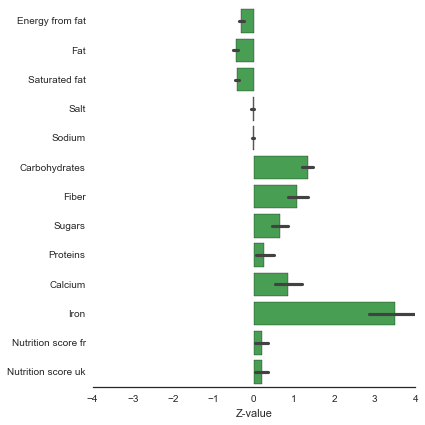

In [17]:
# Plot nutritional profile of the selected cluster
f, ax = plt.subplots(1, 1, figsize=(6, 6))

n_cls0 = len(cls0)

nutrient_names = ['%s' % data[0, i].replace('-', ' ').replace('_', ' ').capitalize()[:-5]
                  for i in range(7, data.shape[1])]*n_cls0
nutrient_data = [X[j, i] for j in cls0 for i in range(X.shape[1])]

to_plot = pd.DataFrame({
        'Nutrients': nutrient_names,
        'Values': nutrient_data
    })
sns.barplot(x='Values', y='Nutrients', data=to_plot, orient='h', color=sns.xkcd_rgb['medium green'])

mx = np.max(np.abs([np.mean(X[cls0, i]) for i in range(X.shape[1])]))
plt.xlim((-mx-.5, mx+.5))

sns.despine(right=True)
sns.despine(left=True)

plt.xlabel('Z-value')
plt.ylabel('')

plt.tight_layout()